<a href="https://colab.research.google.com/github/RafaelBNN/if697/blob/main/Projeto_2_IF697.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A ideia vai ser prever o `Place` de um atleta de acordo com `Age`, `BodyweightKg`, `Sex`, `Division`, `IPFPoints` e `Place` de atletas com atributos semelhantes. O professor sugeriu coletar uma amostra dos últimos 5 anos do dataset original e usar 3,5 anos como *training* set, 0,5 anos como *validation* set e o último ano como *test* set.



*Atualização 27/07*: Acho que esse problema se aplica mais como um problema de regressão, já que não precisamos prever com 100% de certeza a colocação de um competidor. A parte decimal das predições vai nos dar uma ideia da "certeza" do algoritmo de que o competidor vai ficar naquela colocação.

*Atualização 02/08 (acompanhamento)*: Segundo o professor, se formos fazer regressão, deveremos aplicá-la a vários atletas (que talvez tenham participado da mesma competição, não entendi essa parte direito) e rankeá-los de acordo com as previsões, em vez de deixar um número não-inteiro na coluna. Nesse caso, haverá a necessidade de buscarmos registros da mesma competição (na sample que pegamos, temos 1800 registros de 2019; esses registros podem ser, por exemplo de 1800 competições diferentes, e isso talvez não se encaixe na forma com que o professor pensou na solução).

Se fizermos classificação, porém, não parece que teremos esse problema, de modo que o professor não citou "rankear" atletas de acordo com o resultado do modelo (já que não há como rankear classes).

Dado, então, esse problema de ter que buscar registros das mesmas competições para realizar a previsão, parece melhor fazer com classificação, embora o de regressão seja mais fofinho, e acho que faz mais sentido também.

In [10]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [12]:
df=pd.read_csv("https://raw.githubusercontent.com/RafaelBNN/datasets/main/powerlifting_final2.csv")

df.head()

,Unnamed: 0,Unnamed: 0.1,Name,Sex,Event,Equipment,Age,AgeClass,Division,BodyweightKg,WeightClassKg,Squat1Kg,Squat2Kg,Squat3Kg,Best3SquatKg,Bench1Kg,Bench2Kg,Bench3Kg,Best3BenchKg,Deadlift1Kg,Deadlift2Kg,Deadlift3Kg,Best3DeadliftKg,TotalKg,Place,Wilks,McCulloch,Glossbrenner,IPFPoints,Tested,Country,Federation,Date,MeetCountry,MeetState,MeetName,Best3SquatKg_norm,Best3BenchKg_norm,Best3DeadliftKg_norm,TotalKg_norm,BodyweightKg_norm,IPFPoints_norm,TotalKg_disc,lof_outlier
0,0,674206,Dane Roach,1,SBD,Raw,25.500000,24-34,MR-O,81.20,83,157.5,167.5,175.0,175.00,117.5,122.5,127.5,127.50,205.0,220.0,227.5,227.5,530.0,3,358.49,358.49,346.20,525.08,Yes,NaN,USAPL,2017-12-02,USA,MI,Michigan State Meet,-0.340206,-0.409639,0.051948,-0.148760,-0.344148,-0.167948,"(487.5, 551.11]",1
1,1,507347,Cody Robert,1,SBD,Single-ply,23.744319,NaN,Boys,141.52,124.7+,NaN,NaN,NaN,204.12,NaN,NaN,NaN,136.08,NaN,NaN,NaN,183.7,523.9,7,292.29,292.29,276.78,345.78,Yes,NaN,THSPA,2019-02-16,USA,TX,Rice Consolidated Booster Club Meet,-0.220124,-0.368289,-0.175584,-0.158843,0.321525,-0.488504,"(487.5, 551.11]",1
2,2,1054061,Satu Luoto,0,SBD,Raw,46.500000,45-49,Masters 1,62.76,63,122.5,127.5,-132.5,127.50,82.5,85.0,-87.5,85.00,125.0,130.0,-132.5,130.0,342.5,4,368.90,393.98,325.76,593.66,Yes,Finland,IPF,2016-06-19,USA,TX,World Classic Powerlifting Championships,-0.536082,-0.614458,-0.454545,-0.458678,-0.547647,-0.045339,"(308.44, 360.0]",1
3,3,587550,Andreas Andersson,1,SBD,Raw,34.410717,NaN,Juniors 19-23,101.50,105,160.0,170.0,180.0,180.00,120.0,125.0,NaN,125.00,220.0,230.0,-235.0,230.0,535.0,1,323.70,323.70,310.96,456.95,Yes,NaN,NSF,2016-03-02,Norway,NaN,Klubbmesterskap,-0.319588,-0.421687,0.064935,-0.140496,-0.120124,-0.289752,"(487.5, 551.11]",1
4,4,227497,Ben Leyland,1,SBD,Raw,28.671584,NaN,M-C-U23,107.20,120,195.0,207.5,-217.5,207.50,130.0,-132.5,-132.5,130.00,250.0,277.5,290.0,290.0,627.5,2,372.32,372.32,357.01,532.45,Yes,NaN,EPA,2015-07-18,England,NaN,East Midlands Masters Juniors and Novice Champ...,-0.206186,-0.397590,0.376623,0.012397,-0.057220,-0.154772,"(551.11, 632.5]",1


In [13]:
print('Numero de registros de 2015:', len(df[(df['Date']>'2015-01-01')&(df['Date']<'2016-01-01')]))
print('Numero de registros de 2016:', len(df[(df['Date']>'2016-01-01')&(df['Date']<'2017-01-01')]))
print('Numero de registros de 2017:', len(df[(df['Date']>'2017-01-01')&(df['Date']<'2018-01-01')]))
print('Numero de registros de 2018:', len(df[(df['Date']>'2018-01-01')&(df['Date']<'2019-01-01')]))
print('Numero de registros de 2019:', len(df[(df['Date']>'2019-01-01')&(df['Date']<'2020-01-01')]))

Numero de registros de 2015: 3093
Numero de registros de 2016: 3551
Numero de registros de 2017: 4062
Numero de registros de 2018: 4331
Numero de registros de 2019: 1800


Dessa forma, vamos utilizar os anos de 2015 a 2018 para *training* e *validation set* e os registros de 2019 para *test set*.

In [14]:
df['MeetName'] = df['MeetName'].astype('category')

df['MeetName'].cat.categories

Index(['015 Pennsylvania State Bench Press and Deadlift',
       '1. Pitomača Open u powerliftingu & benchpressu',
       '1. Runde Bayernliga Bankdrücken', '1. Runde Bundesliga Kraftdreikampf',
       '1. Runde Sachsen-Ober-Liga im Bankdrücken',
       '1. Wettkampftag Bundesliga Kraftdreikampf',
       '10th Annual Asa Chambless Powerlifting Classic',
       '10th Annual Bristol Big Bench', '10th Annual Fall Championships',
       '10th Annual Forney Jackrabbit Invitational',
       ...
       'Íslandsmeistaramót ungmenna og öldunga í klassískum kraftlyftingum',
       'Íslandsmeistaramót ungmenna og öldunga í kraftlyftingum',
       'Íslandsmeistaramót í bekkpressu',
       'Íslandsmeistaramót í klassískum kraftlyftingum',
       'Íslandsmeistaramót í kraftlyftingum',
       'Íslandsmeistaramót í réttstöðulyftu',
       'Österreichische Staatsmeisterschaft mit Internationalen Cup',
       'Českomoravský Pohár v Klasickém Silovém Trojboji Dorostu a Juniorů',
       'Českomoravský Poh

In [21]:
mask = (df['Date']>'2019-01-01')&(df['Date']<'2020-01-01')

df.loc[mask]

,Unnamed: 0,Unnamed: 0.1,Name,Sex,Event,Equipment,Age,AgeClass,Division,BodyweightKg,WeightClassKg,Squat1Kg,Squat2Kg,Squat3Kg,Best3SquatKg,Bench1Kg,Bench2Kg,Bench3Kg,Best3BenchKg,Deadlift1Kg,Deadlift2Kg,Deadlift3Kg,Best3DeadliftKg,TotalKg,Place,Wilks,McCulloch,Glossbrenner,IPFPoints,Tested,Country,Federation,Date,MeetCountry,MeetState,MeetName,Best3SquatKg_norm,Best3BenchKg_norm,Best3DeadliftKg_norm,TotalKg_norm,BodyweightKg_norm,IPFPoints_norm,TotalKg_disc,lof_outlier
1,1,507347,Cody Robert,1,SBD,Single-ply,23.744319,NaN,Boys,141.52,124.7+,NaN,NaN,NaN,204.12,NaN,NaN,NaN,136.08,NaN,NaN,NaN,183.70,523.90,7,292.29,292.29,276.78,345.78,Yes,NaN,THSPA,2019-02-16,USA,TX,Rice Consolidated Booster Club Meet,-0.220124,-0.368289,-0.175584,-0.158843,0.321525,-0.488504,"(487.5, 551.11]",1
7,8,1119580,Cali Mendonca,0,SBD,Single-ply,24.270429,NaN,Girls,59.33,60.1,NaN,NaN,NaN,79.38,NaN,NaN,NaN,43.09,NaN,NaN,NaN,90.72,213.19,4,239.76,239.76,211.88,346.87,Yes,NaN,THSWPA,2019-01-26,USA,TX,Bullard Invitational,-0.734515,-0.816434,-0.658597,-0.672413,-0.585499,-0.486556,"(212.5, 262.5]",1
18,19,323371,Calvin Poweroy,1,SBD,Single-ply,49.000000,NaN,Boys,116.39,124.7,NaN,NaN,NaN,174.63,NaN,NaN,NaN,97.52,NaN,NaN,NaN,195.04,467.20,8,270.61,270.61,258.62,342.48,Yes,NaN,THSPA,2019-01-10,USA,TX,Midway Powerlifting Invitational,-0.341732,-0.554120,-0.116675,-0.252562,0.044198,-0.494404,"(419.57, 487.5]",1
21,23,334119,Josh Hsu,1,SBD,Single-ply,25.500000,NaN,Boys,113.22,124.7,NaN,NaN,NaN,163.29,NaN,NaN,NaN,65.77,NaN,NaN,NaN,163.29,392.36,20,228.96,228.96,219.07,299.89,Yes,NaN,THSPA,2019-02-09,USA,TX,Longhorn Invitational,-0.388495,-0.707133,-0.281610,-0.376264,0.009215,-0.570547,"(360.0, 419.57]",1
32,34,394449,Davonte Grisham,1,SBD,Single-ply,26.972898,NaN,Boys,71.40,74.8,NaN,NaN,NaN,156.49,NaN,NaN,NaN,90.72,NaN,NaN,NaN,163.29,410.50,12,303.06,303.06,293.50,400.40,Yes,NaN,THSPA,2019-02-02,USA,TX,Rice Bulldog Invitational,-0.416536,-0.586892,-0.281610,-0.346281,-0.452298,-0.390854,"(360.0, 419.57]",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16866,18521,464844,Kingsley Rodriguez,1,SBD,Single-ply,37.000000,NaN,Boys,72.85,74.8,NaN,NaN,NaN,188.24,NaN,NaN,NaN,111.13,NaN,NaN,NaN,192.78,492.15,5,358.01,358.01,346.54,461.62,Yes,NaN,THSPA,2019-01-12,USA,TX,Plainview Invitational,-0.285608,-0.488530,-0.128416,-0.211322,-0.436296,-0.281403,"(487.5, 551.11]",1
16868,18523,1086951,Kaylen Flores,0,SBD,Single-ply,30.500000,NaN,Girls,114.85,117.7,NaN,NaN,NaN,185.97,NaN,NaN,NaN,97.52,NaN,NaN,NaN,142.88,426.38,8,343.70,343.70,291.96,468.34,Yes,NaN,THSWPA,2019-03-02,USA,TX,REGION V DIVISION I CHAMPIONSHIPS,-0.294969,-0.554120,-0.387636,-0.320033,0.027203,-0.269389,"(419.57, 487.5]",1
16869,18524,310372,Cameron Gray,1,SBD,Single-ply,25.000000,NaN,Boys,66.77,67.1,NaN,NaN,NaN,195.04,NaN,NaN,NaN,104.33,NaN,NaN,NaN,199.58,498.95,1,388.08,388.08,376.56,494.18,Yes,NaN,THSPA,2019-01-23,USA,TX,Ranchview Invitational,-0.257567,-0.521301,-0.093091,-0.200083,-0.503393,-0.223192,"(487.5, 551.11]",1
16872,18528,344197,Christopher Laxamana,1,SBD,Single-ply,21.500000,NaN,Boys,65.09,67.1,NaN,NaN,NaN,172.37,NaN,NaN,NaN,92.99,NaN,NaN,NaN,188.24,453.59,4,360.28,360.28,349.88,463.00,Yes,NaN,THSPA,2019-02-07,USA,TX,Iowa Park Invitational,-0.351052,-0.575952,-0.152000,-0.275058,-0.521933,-0.278936,"(419.57, 487.5]",1


# Introdução

Este Notebook busca dar continuidade à análise do dataset estudado no primeiro projeto. Lá, exploramos e tratamos um dataset relacionado a competições de powerlifting, sobre o qual realizamos pré-processeamento e análise descritiva. 

Neste projeto, daremos prosseguimento a isso aplicando a ideia de *predição* dos dados. 

Os problemas de predição aparecem quando queremos descobrir um atributo desconhecido de um registro a partir de outros atributos desse registro. Esses problemas são, principalmente, divididos em duas categorias: problemas de *classificação* e problemas de *regressão*. Na *classificação*, o objetivo é predizer um atributo categórico de um registro, como o sexo de um indivíduo ou a espécie de um animal, por exemplo, enquanto que, na *regressão*, queremos prever um atributo contínuo, como a altura ou o peso de uma pessoa.

A partir do dataset observado, portanto, vamos aplicar o conceito de regressão ao atributo `Place`. Vamos treinar alguns modelos a partir de variados algoritmos de *machine learning* para realizar a predição dessa coluna e avaliar a performance de cada um desses modelos.

# `Place` vs outros atributos 

Inicialmente, vamos buscar analisar possíveis correlações entre o atributo `Place`, que queremos predizer, e outros atributos presentes no dataframe.

In [5]:
df.dtypes

Unnamed: 0                int64
Unnamed: 0.1              int64
Name                     object
Sex                       int64
Event                    object
Equipment                object
Age                     float64
AgeClass                 object
Division                 object
BodyweightKg            float64
WeightClassKg            object
Squat1Kg                float64
Squat2Kg                float64
Squat3Kg                float64
Best3SquatKg            float64
Bench1Kg                float64
Bench2Kg                float64
Bench3Kg                float64
Best3BenchKg            float64
Deadlift1Kg             float64
Deadlift2Kg             float64
Deadlift3Kg             float64
Best3DeadliftKg         float64
TotalKg                 float64
Place                    object
Wilks                   float64
McCulloch               float64
Glossbrenner            float64
IPFPoints               float64
Tested                   object
Country                  object
Federati

In [6]:
df['Name'] = df['Name'].astype('string')
df['Sex'] = df['Sex'].astype('category')                        # astype('char')
df['Event'] = df['Event'].astype('category')                    # astype('string')
df['Equipment'] = df['Equipment'].astype('category')
df['AgeClass'] = df['AgeClass'].astype('category')
df['Division'] = df['Division'].astype('category')
df['WeightClassKg'] = df['WeightClassKg'].astype('category')
df['Place'] = df['Place'].astype('category')                    # astype('int64')
df['Tested'] = df['Tested'].astype('category')
df['Country'] = df['Country'].astype('category')
df['Federation'] = df['Federation'].astype('category')
df['Date'] = df['Date'].astype('category')
df['MeetCountry'] = df['MeetCountry'].astype('category')
df['MeetState'] = df['MeetState'].astype('category')
df['MeetName'] = df['MeetName'].astype('category')
df['Sex'] = df['Sex'].astype('category')

In [9]:
(df['Division'].cat.categories)

Index(['12-13', '14-15', '20-23', '24-39', '40-44', '45-49', '50-54', '55+',
       '55-59', '60+',
       ...
       'wsm1', 'wsm2', 'wsmp', 'wteen', 'wyouth', 'youth', 'М1 40-49', 'М2',
       'М3', 'М3 60-69'],
      dtype='object', length=857)

In [ ]:
#df['Name'] = df['Name'].cat.codes
df['Sex'] = df['Sex'].cat.codes
df['Event'] = df['Event'].cat.codes
df['Equipment'] = df['Equipment'].cat.codes
df['AgeClass'] = df['AgeClass'].cat.codes
df['Division'] = df['Division'].cat.codes
df['WeightClassKg'] = df['WeightClassKg'].cat.codes
df['Place'] = df['Place'].cat.codes
df['Tested'] = df['Tested'].cat.codes
df['Country'] = df['Country'].cat.codes
df['Federation'] = df['Federation'].cat.codes
df['Date'] = df['Date'].cat.codes
df['MeetCountry'] = df['MeetCountry'].cat.codes
df['MeetState'] = df['MeetState'].cat.codes
df['MeetName'] = df['MeetName'].cat.codes

In [ ]:
df.dtypes

Unnamed: 0                int64
Unnamed: 0.1              int64
Name                     string
Sex                        int8
Event                      int8
Equipment                  int8
Age                     float64
AgeClass                   int8
Division                  int16
BodyweightKg            float64
WeightClassKg              int8
Squat1Kg                float64
Squat2Kg                float64
Squat3Kg                float64
Best3SquatKg            float64
Bench1Kg                float64
Bench2Kg                float64
Bench3Kg                float64
Best3BenchKg            float64
Deadlift1Kg             float64
Deadlift2Kg             float64
Deadlift3Kg             float64
Best3DeadliftKg         float64
TotalKg                 float64
Place                      int8
Wilks                   float64
McCulloch               float64
Glossbrenner            float64
IPFPoints               float64
Tested                     int8
Country                    int8
Federati

In [ ]:
df.drop(labels='Name',axis=1,inplace=True)

In [ ]:
df.head()

,Unnamed: 0,Unnamed: 0.1,Sex,Event,Equipment,Age,AgeClass,Division,BodyweightKg,WeightClassKg,Squat1Kg,Squat2Kg,Squat3Kg,Best3SquatKg,Bench1Kg,Bench2Kg,Bench3Kg,Best3BenchKg,Deadlift1Kg,Deadlift2Kg,Deadlift3Kg,Best3DeadliftKg,TotalKg,Place,Wilks,McCulloch,Glossbrenner,IPFPoints,Tested,Country,Federation,Date,MeetCountry,MeetState,MeetName,Best3SquatKg_norm,Best3BenchKg_norm,Best3DeadliftKg_norm,TotalKg_norm,BodyweightKg_norm,IPFPoints_norm,TotalKg_disc,lof_outlier
0,0,674206,1,5,1,25.500000,5,491,81.20,85,157.5,167.5,175.0,175.00,117.5,122.5,127.5,127.50,205.0,220.0,227.5,227.5,530.0,23,358.49,358.49,346.20,525.08,1,0,113,623,68,41,2493,-0.340206,-0.409639,0.051948,-0.148760,-0.344148,-0.167948,"(487.5, 551.11]",1
1,1,507347,1,5,2,23.744319,0,68,141.52,19,NaN,NaN,NaN,204.12,NaN,NaN,NaN,136.08,NaN,NaN,NaN,183.7,523.9,51,292.29,292.29,276.78,345.78,1,0,107,898,68,88,3502,-0.220124,-0.368289,-0.175584,-0.158843,0.321525,-0.488504,"(487.5, 551.11]",1
2,2,1054061,0,5,1,46.500000,8,628,62.76,57,122.5,127.5,-132.5,127.50,82.5,85.0,-87.5,85.00,125.0,130.0,-132.5,130.0,342.5,30,368.90,393.98,325.76,593.66,1,27,59,317,68,88,4635,-0.536082,-0.614458,-0.454545,-0.458678,-0.547647,-0.045339,"(308.44, 360.0]",1
3,3,587550,1,5,1,34.410717,0,284,101.50,3,160.0,170.0,180.0,180.00,120.0,125.0,NaN,125.00,220.0,230.0,-235.0,230.0,535.0,0,323.70,323.70,310.96,456.95,1,0,78,256,46,0,2148,-0.319588,-0.421687,0.064935,-0.140496,-0.120124,-0.289752,"(487.5, 551.11]",1
4,4,227497,1,5,1,28.671584,0,328,107.20,16,195.0,207.5,-217.5,207.50,130.0,-132.5,-132.5,130.00,250.0,277.5,290.0,290.0,627.5,12,372.32,372.32,357.01,532.45,1,0,30,121,17,0,1351,-0.206186,-0.397590,0.376623,0.012397,-0.057220,-0.154772,"(551.11, 632.5]",1


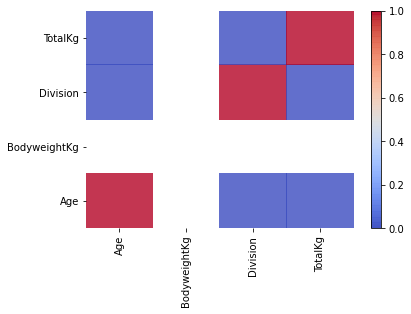

In [ ]:
import matplotlib as mpl

def visualize_correlation_matrix(data, hurdle = 0.0):
    R = np.corrcoef(data, rowvar=0)
    R[np.where(np.abs(R)<hurdle)] = 0.0
    heatmap = plt.pcolor(R, cmap=mpl.cm.coolwarm, alpha=0.8)
    heatmap.axes.set_frame_on(False)
    heatmap.axes.set_yticks(np.arange(R.shape[0]) + 0.5, minor=False)
    heatmap.axes.set_xticks(np.arange(R.shape[1]) + 0.5, minor=False)
    heatmap.axes.set_xticklabels(data.columns, minor=False)
    plt.xticks(rotation=90)
    heatmap.axes.set_yticklabels(data.columns, minor=False)
    plt.tick_params(which='True', bottom='True', top='False', left = 'False', right = 'False')
    plt.colorbar()
    plt.show()

visualize_correlation_matrix(df.loc[:,['Age','BodyweightKg','Division','TotalKg']], hurdle=0.5)

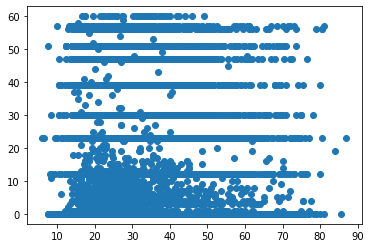

In [ ]:
#figs, axes = plt.subplots(2,3,figsize=(15,7))
#dataset[['RM','target']].plot.scatter(x='RM',y='target',ax=axes[0,0])
#dataset[['PTRATIO','target']].plot.scatter(x='PTRATIO',y='target',ax=axes[0,1])
#dataset[['LSTAT','target']].plot.scatter(x='LSTAT',y='target',ax=axes[0,2])
#dataset[['CRIM','target']].plot.scatter(x='CRIM',y='target',ax=axes[1,0])
#dataset[['AGE','target']].plot.scatter(x='AGE',y='target',ax=axes[1,1])
#dataset[['TAX','target']].plot.scatter(x='TAX',y='target',ax=axes[1,2])


plt.scatter(x=df['Age'],y=df['Place'])


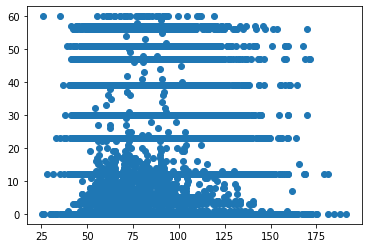

In [ ]:
plt.scatter(x=df['BodyweightKg'],y=df['Place'])

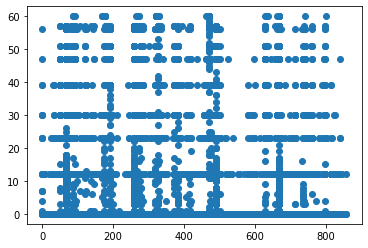

In [ ]:
plt.scatter(x=df['Division'],y=df['Place'])